In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import signal
from scipy.fft import fft, fftfreq
import pylab
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import mean_squared_error

## Import Data
    available paths: 
    
    EMG DATA:
        - subject1_open_5.xlsx XXX
        - subject1_smile_1.xlsx Spike in right ocul.
        - subject1_smile_4.xlsx Spike in right ocul.
    FAME DATA:
        - subject1_smile_1_landmarks.csv
        - subject1_smile_4_landmarks.csv

In [2]:
df = pd.read_excel('subject1_smile_1.xlsx')

## Sensor Labels
    EMG 1 = a; left side of face
    EMG 2 = b; right side of face
    Ch a-d = 1-4; a-d, indicated by sensor color

## Characteristics

In [3]:
fs = 2000
t_ttt = df['time'].iloc[-1]
N_samples = fs*t_ttt

char = {
  "seconds": t_ttt,
  "N": N_samples,
  "fs": fs
}
intro = "EMG data:"+"\n"+"%s seconds long with a total of %s samples at %s Hz."%(t_ttt,N_samples,fs)
print(intro)

EMG data:
27.496500000000033 seconds long with a total of 54993.000000000065 samples at 2000 Hz.


In [45]:
df.head

<bound method NDFrame.head of           time             a1             a2             a3             a4  \
0       0.0000  -6.017704e-13  -9.593442e-13  -9.855081e-13  -7.936393e-13   
1       0.0005  -5.094890e-07  -8.122304e-07  -8.343824e-07  -6.719360e-07   
2       0.0010  -1.052261e-05  -1.689578e-05  -1.738180e-05  -1.397741e-05   
3       0.0015  -1.165233e-05  -2.011176e-05  -2.109853e-05  -1.655467e-05   
4       0.0020  -1.120676e-05  -1.834543e-05  -2.033471e-05  -1.441966e-05   
...        ...            ...            ...            ...            ...   
54989  27.4945 -7.007562e-126 -7.765490e-126 -9.539230e-126 -1.049939e-125   
54990  27.4950  2.417320e-126  2.683538e-126  3.285782e-126  3.622868e-126   
54991  27.4955 -8.040092e-127 -8.945879e-127 -1.090789e-126 -1.205411e-126   
54992  27.4960  2.546680e-127  2.842589e-127  3.445868e-127  3.820024e-127   
54993  27.4965 -7.502182e-128 -8.415737e-128 -1.010839e-127 -1.126218e-127   

                  b1             

## Call and Assign variables for EMG and convert to microV 

In [4]:
# df_mean = df.apply(lambda x:x - x.mean()) # removing mean bias
# df_mean['time'] = df['time']
# df = df_mean

time = df['time']

emg1 = df['a1']*(10**6)
emg2 = df['a2']*(10**6)
emg3 = df['a3']*(10**6)
emg4 = df['a4']*(10**6)
left_side = [emg1,emg2,emg3,emg4]

emg5 = df['b1']*(10**6)
emg6 = df['b2']*(10**6)
emg7 = df['b3']*(10**6)
emg8 = df['b4']*(10**6)
right_side = [emg4,emg5,emg6,emg7]

m1 = "Dep. anguli oris"
m2 = "Orbicularis Oris (l)"
m3 = "Zygomaticus Major"
m4 = "Orbicularis Oculi"

a1 = "L.Dep. anguli oris"
a2 = "L.Orbicularis Oris (l)"
a3 = "L.Zyg. Major"
a4 = "L.Orbiculis Oculi"

b1 = "R.Dep. anguli oris"
b2 = "R.Orbicularis Oris (l)"
b3 = "R.Zyg. major"
b4 = "R.Orbicularis Oculi"

l = "left"
r = "right"

def despike(yi, th=5.e-8):
  y = np.copy(yi) # use y = y1 if it is OK to modify input array
  n = len(y)
  x = np.arange(n)
  c = np.argmax(y)
  d = abs(np.diff(y))
  try:
    l = c - 1 - np.where(d[c-1::-1]<th)[0][0]
    r = c + np.where(d[c:]<th)[0][0] + 1
  except: # no spike, return unaltered array
    return y
  # for fit, use area twice wider then the spike
  if (r-l) <= 3:
    l -= 1
    r += 1
  s = int(round((r-l)/2.))
  lx = l - s
  rx = r + s
  # make a gap at spike area
  xgapped = np.concatenate((x[lx:l],x[r:rx]))
  ygapped = np.concatenate((y[lx:l],y[r:rx]))
  # quadratic fit of the gapped array
  z = np.polyfit(xgapped,ygapped,2)
  p = np.poly1d(z)
  y[l:r] = p(x[l:r])
  return y

despike(emg8,th = 200.e-8)

## Plot Raw EMG Data

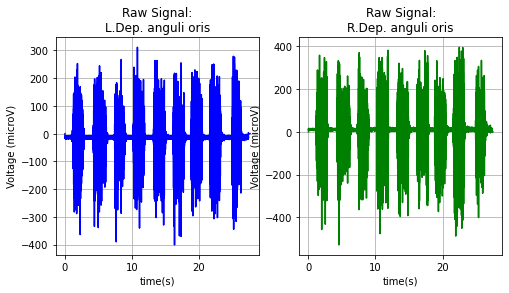

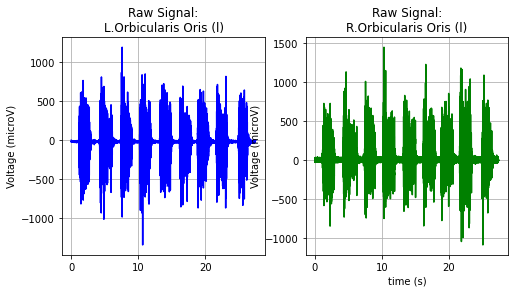

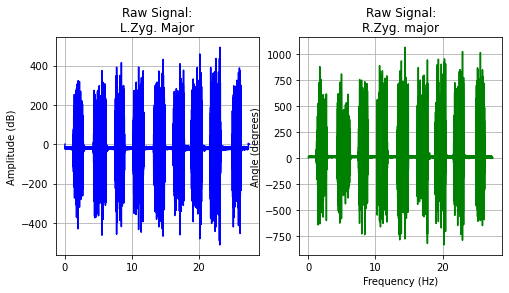

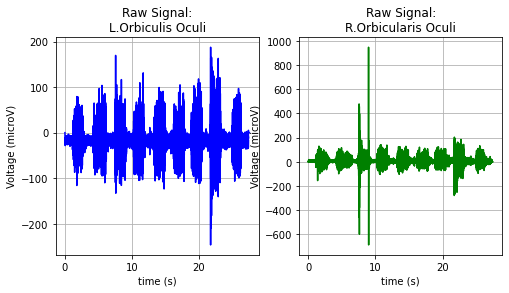

In [5]:
# m1 = "Dep. anguli oris"

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(df['time'], emg1, color='blue',label = '%s'%l)
ax[0].set_title("Raw Signal:" + "\n" + "%s"%a1)
ax[0].set_ylabel("Voltage (microV)")
ax[0].set_xlabel("time(s)")
ax[0].grid()
ax[0].autoscale()

ax[1].plot(df['time'], emg5, color='green', label = '%s'%r)
ax[1].set_title("Raw Signal:" + "\n" + "%s"%b1)
ax[1].set_ylabel("Voltage (microV)")
ax[1].set_xlabel("time(s)")
ax[1].grid()
ax[1].autoscale()

#m2 = "Orbicularis Oris (l)"

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(df['time'], emg2, color='blue',label = '%s'%l)
ax[0].set_title("Raw Signal:" + "\n" + "%s"%a2)
ax[0].set_ylabel("Voltage (microV)")
ax[1].set_xlabel("time (s)")

ax[0].grid()
ax[0].autoscale()

ax[1].plot(df['time'], emg6, color='green', label = '%s'%r)
ax[1].set_title("Raw Signal:" + "\n" + "%s"%b2)
ax[1].set_ylabel("Voltage (microV)")
ax[1].set_xlabel("time (s)")
ax[1].grid()
ax[1].autoscale()

# m3 = "Zyg. Major"

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(df['time'], emg3, color='blue',label = '%s'%l)
ax[0].set_title("Raw Signal:" + "\n" + "%s"%a3)
ax[0].set_ylabel("Amplitude (dB)")
ax[0].grid()
ax[0].autoscale()

ax[1].plot(df['time'], emg7, color='green', label = '%s'%r)
ax[1].set_title("Raw Signal:" + "\n" + "%s"%b3)
ax[1].set_ylabel("Angle (degrees)")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].grid()
ax[1].autoscale()

# m4 = "Orbiculis Oculi"
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(df['time'], emg4, color='blue',label = '%s'%l)
ax[0].set_title("Raw Signal:" + "\n" + "%s"%a4)
ax[0].set_ylabel("Voltage (microV)")
ax[0].set_xlabel("time (s)")
ax[0].grid()
ax[0].autoscale()

ax[1].plot(df['time'], emg8, color='green', label = '%s'%r)
ax[1].set_title("Raw Signal:" + "\n" + "%s"%b4)
ax[1].set_ylabel("Voltage (microV)")
ax[1].set_xlabel("time (s)")
ax[1].grid()
ax[1].autoscale()

## Design Bandpass Filter

In [6]:
df.head()

,time,a1,a2,a3,a4,b1,b2,b3,b4
0,0.0000,-6.017704e-13,-9.593442e-13,-9.855081e-13,-7.936393e-13,7.325901e-13,1.404131e-12,5.843278e-13,2.703606e-13
1,0.0005,-5.094890e-07,-8.122304e-07,-8.343824e-07,-6.719360e-07,6.202469e-07,1.188809e-06,4.947228e-07,2.289007e-07
2,0.0010,-1.052261e-05,-1.689578e-05,-1.738180e-05,-1.397741e-05,1.276352e-05,2.464100e-05,1.034150e-05,4.711096e-06
3,0.0015,-1.165233e-05,-2.011176e-05,-2.109853e-05,-1.655467e-05,1.328889e-05,2.811801e-05,1.278868e-05,4.918559e-06
4,0.0020,-1.120676e-05,-1.834543e-05,-2.033471e-05,-1.441966e-05,1.067679e-05,2.423735e-05,1.048404e-05,3.556361e-06


In [7]:
# process EMG signal: filter EMG BANDPASS
low_band = 1
high_band = 400
order_bp = 2
z1, w1 = sp.signal.bessel(order_bp, [low_band,high_band], btype='bandpass',analog = False, output= 'ba', fs = 2000)

## Bandpass Filter Response 
    NEED: Hass error - "dividing by 0"
    -dbode analog TF 

C:\Anaconda\lib\site-packages\scipy\signal\ltisys.py:3837: RuntimeWarning: divide by zero encountered in log10
  mag = 20.0 * numpy.log10(abs(y))


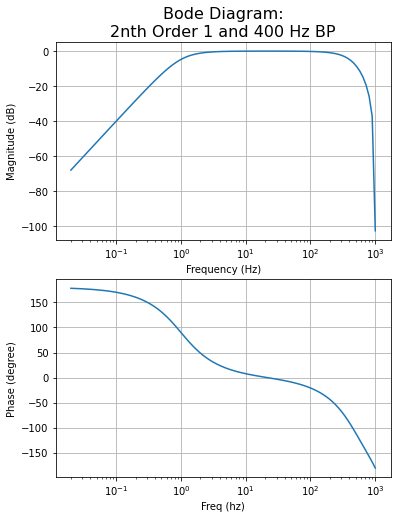

In [8]:
sys_bp = signal.dlti(z1, w1, dt = 1/fs)
w_bp, mag_bp, phase_bp = signal.dbode(sys_bp, w = np.logspace(-2,3,100)*2*np.pi)
w_bp, mag_bp, phase_bp = sys_bp.bode(w = (np.logspace(-2,2.7,100)*2*np.pi)/(fs/2))
fs = 2000

low_cut = low_band
high_cut = high_band


freq_bp = w_bp/(2*np.pi)

fig, ax = plt.subplots(2,1,figsize = (6,8))
ax[0].semilogx(freq_bp, mag_bp)  
ax[0].set_title(r'Bode Diagram:'+ '\n' + '%snth Order %s and %s Hz BP'%(order_bp,low_band,high_band), fontsize=16)
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Magnitude (dB)')
#ax[0].autoscale()
ax[0].grid()

ax[1].semilogx(freq_bp, phase_bp) 
ax[1].set_ylabel("Phase (degree)")
ax[1].set_xlabel("Freq (hz)")
#ax[1].autoscale()
ax[1].grid()
plt.show()

## Apply Bandpass Filter

In [9]:
fs = 2000

band_a1 = sp.signal.filtfilt(z1, w1, emg1)
band_a2 = sp.signal.filtfilt(z1, w1, emg2)
band_a3 = sp.signal.filtfilt(z1, w1, emg3)
band_a4 = sp.signal.filtfilt(z1, w1, emg4)
band_b1 = sp.signal.filtfilt(z1, w1, emg5)
band_b2 = sp.signal.filtfilt(z1, w1, emg6)
band_b3 = sp.signal.filtfilt(z1, w1, emg7)
band_b4 = sp.signal.filtfilt(z1, w1, emg8)


## Comparison: Bandpassed left vs. right

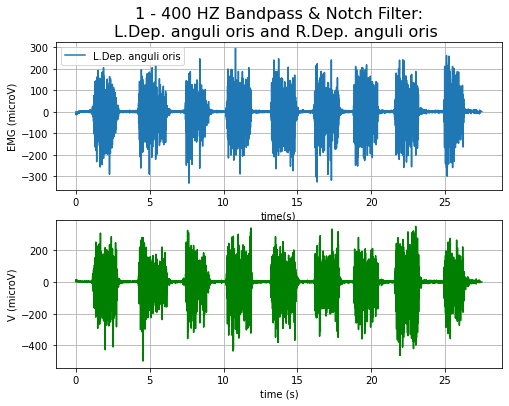

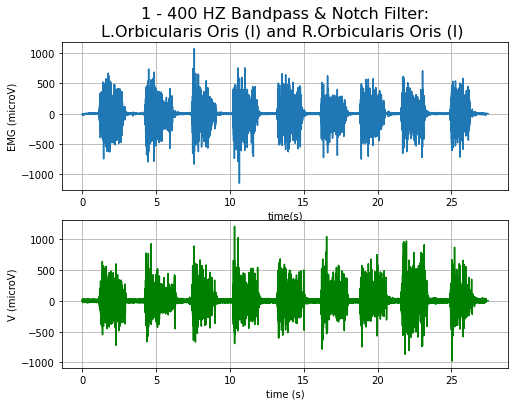

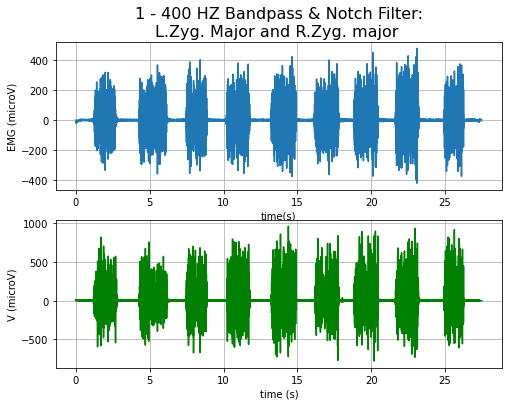

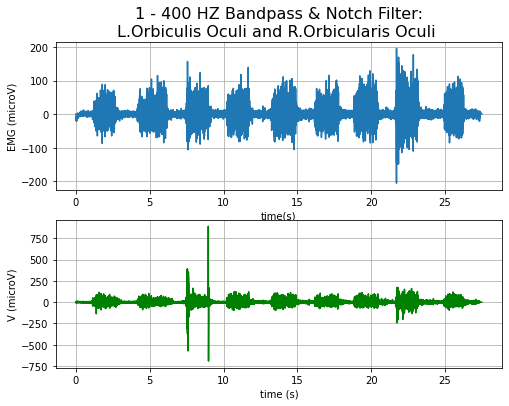

In [10]:

# process EMG signal: filter EMG LOWPASS
fig, ax = plt.subplots(2,1,figsize = (8,6))
ax[0].plot(df['time'], band_a1,label = "%s"%a1)
ax[0].set_title(r'%s - %s HZ Bandpass & Notch Filter:'%(low_band,high_band)+ '\n' + '%s and %s '%(a1,b1), fontsize=16)
ax[0].set_xlabel('time(s)')
ax[0].set_ylabel('EMG (microV)')
ax[0].autoscale()
ax[0].legend()
ax[0].grid()

ax[1].plot(df['time'], band_b1,'g')
ax[1].set_ylabel("V (microV)")
ax[1].set_xlabel("time (s)")
ax[1].autoscale()
ax[1].grid()

fig, ax = plt.subplots(2,1,figsize = (8,6))
ax[0].plot(df['time'], band_a2)
ax[0].set_title(r'%s - %s HZ Bandpass & Notch Filter:'%(low_band,high_band)+ '\n' + '%s and %s '%(a2,b2), fontsize=16)
ax[0].set_xlabel('time(s)')
ax[0].set_ylabel('EMG (microV)')
ax[0].autoscale()
ax[0].grid()

ax[1].plot(df['time'], band_b2,'g')
ax[1].set_ylabel("V (microV)")
ax[1].set_xlabel("time (s)")
ax[1].autoscale()
ax[1].grid()

fig, ax = plt.subplots(2,1,figsize = (8,6))
ax[0].plot(df['time'], band_a3)
ax[0].set_title(r'%s - %s HZ Bandpass & Notch Filter:'%(low_band,high_band)+ '\n' + '%s and %s '%(a3,b3), fontsize=16)
ax[0].set_xlabel('time(s)')
ax[0].set_ylabel('EMG (microV)')
ax[0].autoscale()
ax[0].grid()

ax[1].plot(df['time'], band_b3,'g')
ax[1].set_ylabel("V (microV)")
ax[1].set_xlabel("time (s)")
ax[1].autoscale()
ax[1].grid()

fig, ax = plt.subplots(2,1,figsize = (8,6))
ax[0].plot(df['time'], band_a4)
ax[0].set_title(r'%s - %s HZ Bandpass & Notch Filter:'%(low_band,high_band)+ '\n' + '%s and %s '%(a4,b4), fontsize=16)
ax[0].set_xlabel('time(s)')
ax[0].set_ylabel('EMG (microV)')
ax[0].autoscale()
ax[0].grid()

ax[1].plot(df['time'], band_b4,'g')
ax[1].set_ylabel("V (microV)")
ax[1].set_xlabel("time (s)")
ax[1].autoscale()
ax[1].grid()
plt.show()

## Raw PSD

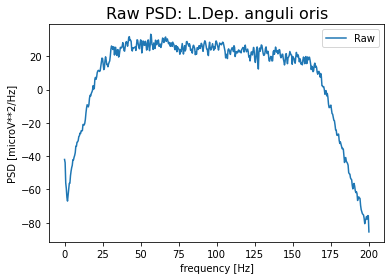

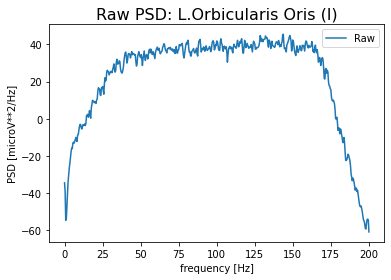

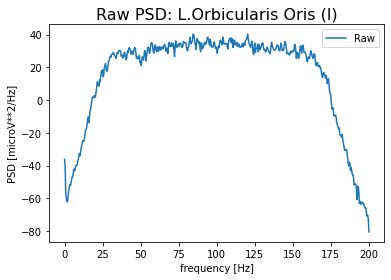

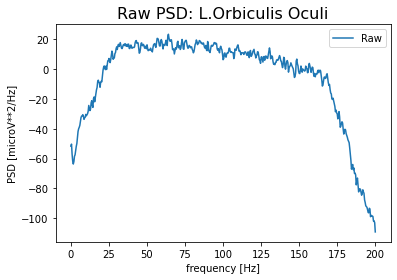

In [11]:
fs = 2000

f1, Pxx_raw_den_a1 = signal.welch(signal.decimate(emg1,5), fs/5, nperseg=1024)
f2, Pxx_raw_den_a2 = signal.welch(signal.decimate(emg2,5), fs/5, nperseg=1024)
f3, Pxx_raw_den_a3 = signal.welch(signal.decimate(emg3,5), fs/5, nperseg=1024)
f4, Pxx_raw_den_a4 = signal.welch(signal.decimate(emg4,5), fs/5, nperseg=1024)

fig, ax = plt.subplots()
ax.plot(f1, 20*np.log10(np.abs(Pxx_raw_den_a1)),label = "Raw" )
ax.set_title(r'Raw PSD: %s'%a1, fontsize=16)
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [microV**2/Hz]')
leg = ax.legend()


fig, ax = plt.subplots()
ax.plot(f2, 20*np.log10(np.abs(Pxx_raw_den_a2)), label = "Raw")
ax.set_title(r'Raw PSD: %s'%a2, fontsize=16)
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [microV**2/Hz]')
leg = ax.legend()

fig, ax = plt.subplots()
ax.plot(f3, 20*np.log10(np.abs(Pxx_raw_den_a3)),label = "Raw")
ax.set_title(r'Raw PSD: %s'%a2, fontsize=16)
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [microV**2/Hz]')
leg = ax.legend()


fig, ax = plt.subplots()
ax.plot(f4, 20*np.log10(np.abs(Pxx_raw_den_a4)),label = "Raw")
ax.set_title(r'Raw PSD: %s'%a4, fontsize=16)
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [microV**2/Hz]')
leg = ax.legend()

## Rectifying Signal

In [12]:
# rectify bandpassed signal 
abs_a1 = np.abs(band_a1)
abs_a2 = np.abs(band_a2)
abs_a3 = np.abs(band_a3)
abs_a4 = np.abs(band_a4)
abs_b1 = np.abs(band_b1)
abs_b2 = np.abs(band_b2)
abs_b3 = np.abs(band_b3)
abs_b4 = np.abs(band_b4)

## Rectified Signal Plot

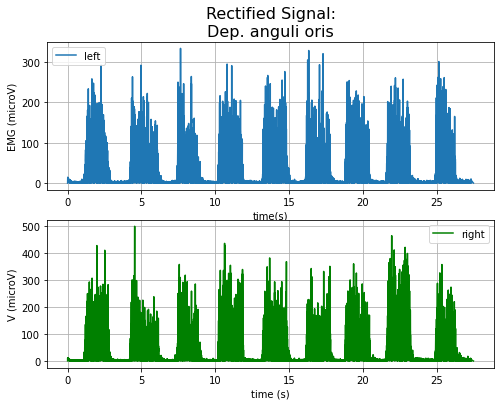

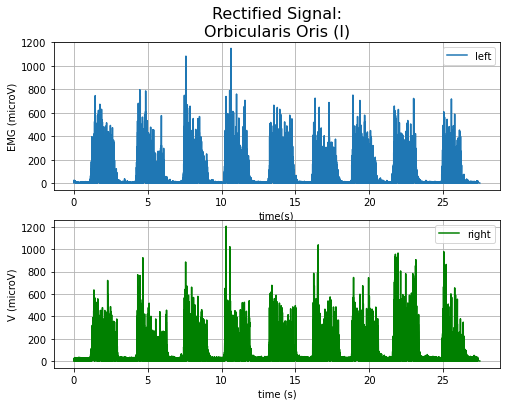

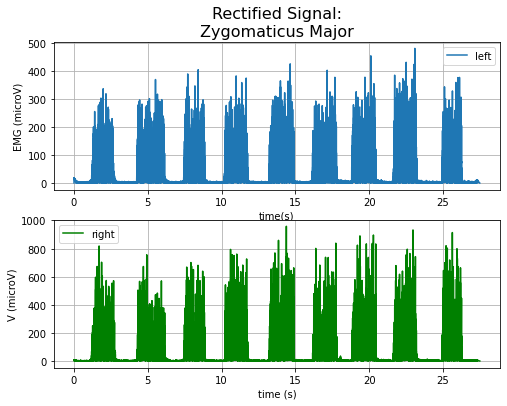

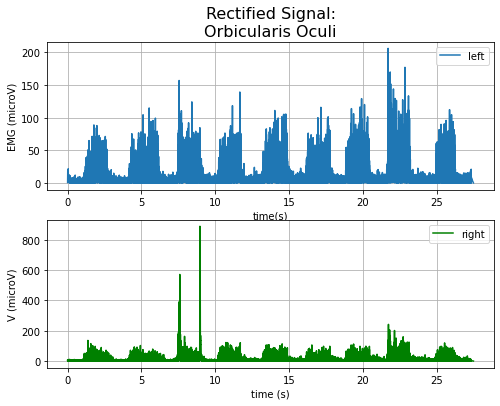

In [13]:
fig, ax = plt.subplots(2,1,figsize = (8,6))
ax[0].plot(df['time'], abs_a1, label = '%s'%l)
ax[0].set_title(r'Rectified Signal:'+ '\n' + '%s'%m1, fontsize=16)
ax[0].set_xlabel('time(s)')
ax[0].set_ylabel('EMG (microV)')
ax[0].autoscale()
ax[0].grid()
leg = ax[0].legend()

ax[1].plot(df['time'], abs_b1,'g',label = '%s'%r)
ax[1].set_ylabel("V (microV)")
ax[1].set_xlabel("time (s)")
ax[1].autoscale()
ax[1].grid()
leg = ax[1].legend()

fig, ax = plt.subplots(2,1,figsize = (8,6))
ax[0].plot(df['time'], abs_a2, label = '%s'%l)
ax[0].set_title(r'Rectified Signal:'+ '\n' + '%s'%m2, fontsize=16)
ax[0].set_xlabel('time(s)')
ax[0].set_ylabel('EMG (microV)')
ax[0].autoscale()
ax[0].grid()
leg = ax[0].legend()

ax[1].plot(df['time'], abs_b2,'g',label = '%s'%r)
ax[1].set_ylabel("V (microV)")
ax[1].set_xlabel("time (s)")
ax[1].autoscale()
ax[1].grid()
leg = ax[1].legend()

fig, ax = plt.subplots(2,1,figsize = (8,6))
ax[0].plot(df['time'], abs_a3, label = '%s'%l)
ax[0].set_title(r'Rectified Signal:'+ '\n' + '%s'%m3, fontsize=16)
ax[0].set_xlabel('time(s)')
ax[0].set_ylabel('EMG (microV)')
ax[0].autoscale()
ax[0].grid()
leg = ax[0].legend()

ax[1].plot(df['time'], abs_b3,'g',label = '%s'%r)
ax[1].set_ylabel("V (microV)")
ax[1].set_xlabel("time (s)")
ax[1].autoscale()
ax[1].grid()
leg = ax[1].legend()

fig, ax = plt.subplots(2,1,figsize = (8,6))
ax[0].plot(df['time'], abs_a4, label = '%s'%l)
ax[0].set_title(r'Rectified Signal:'+ '\n' + '%s'%m4, fontsize=16)
ax[0].set_xlabel('time(s)')
ax[0].set_ylabel('EMG (microV)')
ax[0].autoscale()
ax[0].grid()
leg = ax[0].legend()

ax[1].plot(df['time'], abs_b4,'g',label = '%s'%r)
ax[1].set_ylabel("V (microV)")
ax[1].set_xlabel("time (s)")
ax[1].autoscale()
ax[1].grid()
leg = ax[1].legend()

plt.show()

## Design Lowpass Filter - 2nd Order Bessel 

In [14]:
fc_low = 25
fs = 2000
lp_order = 2
z2, w2 = sp.signal.bessel(lp_order, Wn = fc_low/ (fs / 2), btype = 'lowpass')

## Lowpass Bode Plot

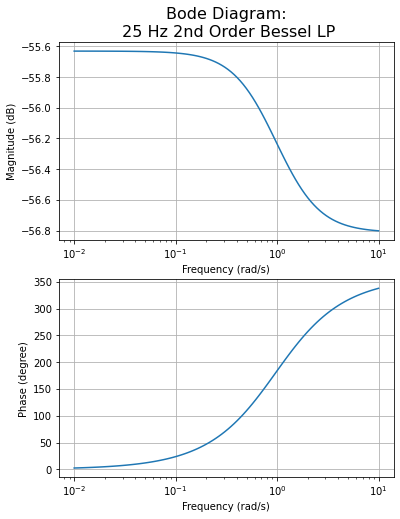

In [15]:
sys = signal.TransferFunction(z2, w2)
w, mag, phase = signal.bode(sys)

fig, ax = plt.subplots(2,1,figsize = (6,8))
ax[0].semilogx(w, mag)  
ax[0].set_title(r'Bode Diagram:'+ '\n' + ' %s Hz 2nd Order Bessel LP'%fc_low, fontsize=16)
ax[0].set_xlabel('Frequency (rad/s)')
ax[0].set_ylabel('Magnitude (dB)')
ax[0].autoscale()
ax[0].grid()

ax[1].semilogx(w, phase) 
ax[1].set_ylabel("Phase (degree)")
ax[1].set_xlabel("Frequency (rad/s)")
ax[1].autoscale()
ax[1].grid()
plt.show()

## Apply Lowpass Filter
    apply with filtfilt, double-pass 0 lag. 

In [16]:
#Apply filter
filt_a1 = sp.signal.filtfilt(z2, w2, abs_a1)
filt_a2 = sp.signal.filtfilt(z2, w2, abs_a2)
filt_a3 = sp.signal.filtfilt(z2, w2, abs_a3)
filt_a4 = sp.signal.filtfilt(z2, w2, abs_a4)
filt_b1 = sp.signal.filtfilt(z2, w2, abs_b1)
filt_b2 = sp.signal.filtfilt(z2, w2, abs_b2)
filt_b3 = sp.signal.filtfilt(z2, w2, abs_b3)
filt_b4 = sp.signal.filtfilt(z2, w2, abs_b4)

## Rectified vs Lowpassed
    (next step, basically)

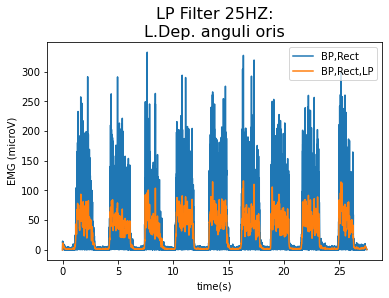

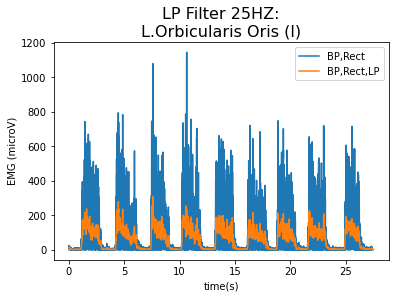

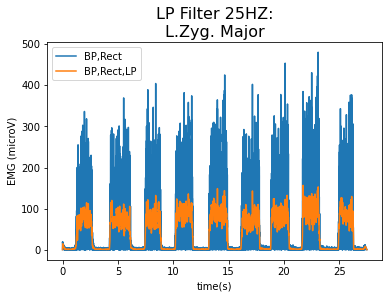

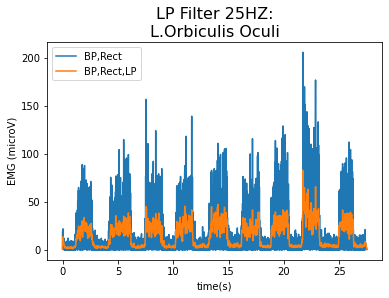

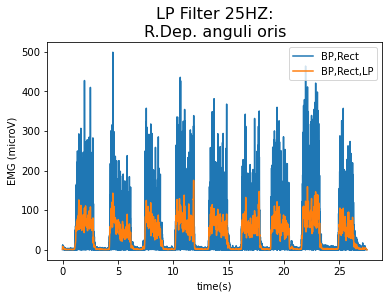

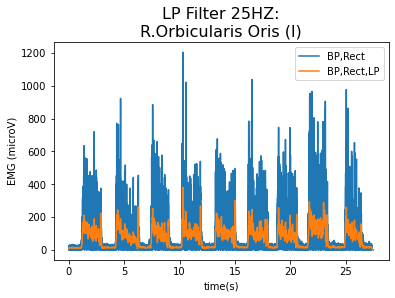

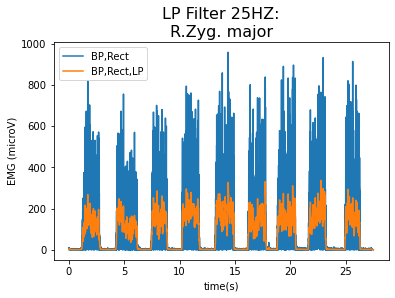

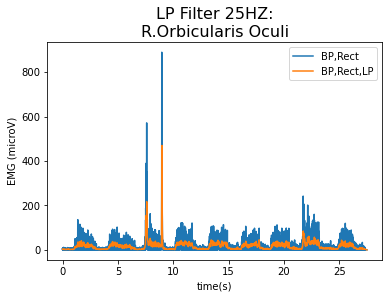

In [17]:
#BP + Rectified,and BP + LP signal

fig, ax = plt.subplots()
ax.plot(df['time'], abs_a1,label = 'BP,Rect')
ax.plot(df['time'], filt_a1,label = 'BP,Rect,LP')
ax.set_title(r'LP Filter %sHZ:'%fc_low+ '\n' + '%s'%a1, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'], abs_a2,label = 'BP,Rect')
ax.plot(df['time'], filt_a2,label = 'BP,Rect,LP')
ax.set_title(r'LP Filter %sHZ:'%fc_low+ '\n' + '%s'%a2, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'], abs_a3,label = 'BP,Rect')
ax.plot(df['time'], filt_a3,label = 'BP,Rect,LP')
ax.set_title(r'LP Filter %sHZ:'%fc_low+ '\n' + '%s'%a3, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'], abs_a4,label = 'BP,Rect')
ax.plot(df['time'], filt_a4,label = 'BP,Rect,LP')
ax.set_title(r'LP Filter %sHZ:'%fc_low+ '\n' + '%s'%a4, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'], abs_b1,label = 'BP,Rect')
ax.plot(df['time'], filt_b1,label = 'BP,Rect,LP')
ax.set_title(r'LP Filter %sHZ:'%fc_low+ '\n' + '%s'%b1, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'], abs_b2,label = 'BP,Rect')
ax.plot(df['time'], filt_b2,label = 'BP,Rect,LP')
ax.set_title(r'LP Filter %sHZ:'%fc_low+ '\n' + '%s'%b2, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'], abs_b3,label = 'BP,Rect')
ax.plot(df['time'], filt_b3,label = 'BP,Rect,LP')
ax.set_title(r'LP Filter %sHZ:'%fc_low+ '\n' + '%s'%b3, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'], abs_b4,label = 'BP,Rect')
ax.plot(df['time'], filt_b4,label = 'BP,Rect,LP')
ax.set_title(r'LP Filter %sHZ:'%fc_low+ '\n' + '%s'%b4, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()
plt.show()

## Lowpassed Signal Comparison by Muscle Group

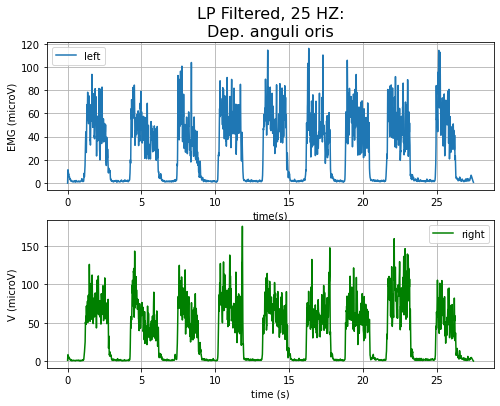

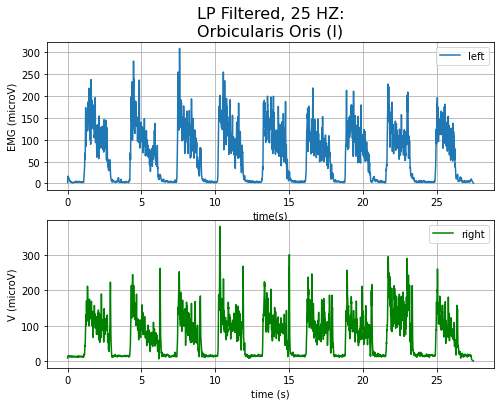

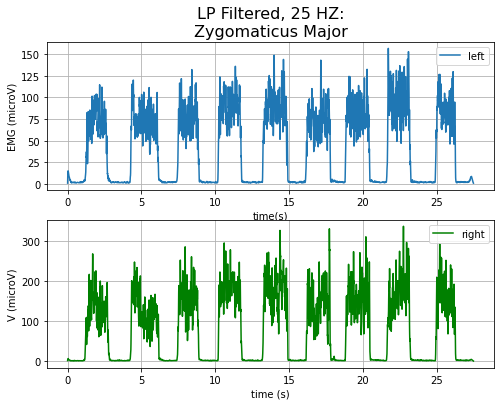

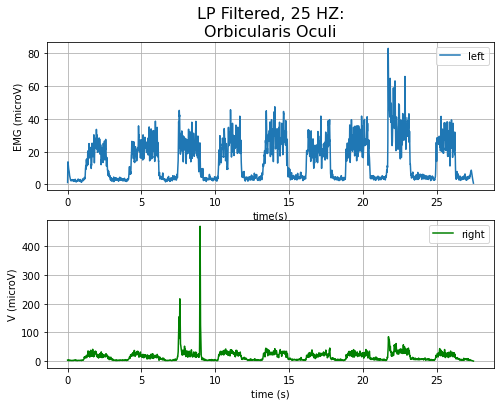

In [18]:
fig, ax = plt.subplots(2,1,figsize = (8,6))
ax[0].plot(df['time'], filt_a1, label = '%s'%l)
ax[0].set_title(r'LP Filtered, %s HZ:'%fc_low+ '\n' + '%s'%m1, fontsize=16)
ax[0].set_xlabel('time(s)')
ax[0].set_ylabel('EMG (microV)')
ax[0].autoscale()
ax[0].grid()
leg = ax[0].legend()

ax[1].plot(df['time'], filt_b1,'g',label = '%s'%r)
ax[1].set_ylabel("V (microV)")
ax[1].set_xlabel("time (s)")
ax[1].autoscale()
ax[1].grid()
leg = ax[1].legend()

fig, ax = plt.subplots(2,1,figsize = (8,6))
ax[0].plot(df['time'], filt_a2, label = '%s'%l)
ax[0].set_title(r'LP Filtered, %s HZ:'%fc_low+ '\n' + '%s'%m2, fontsize=16)
ax[0].set_xlabel('time(s)')
ax[0].set_ylabel('EMG (microV)')
ax[0].autoscale()
ax[0].grid()
leg = ax[0].legend()

ax[1].plot(df['time'], filt_b2,'g',label = '%s'%r)
ax[1].set_ylabel("V (microV)")
ax[1].set_xlabel("time (s)")
ax[1].autoscale()
ax[1].grid()
leg = ax[1].legend()

fig, ax = plt.subplots(2,1,figsize = (8,6))
ax[0].plot(df['time'], filt_a3, label = '%s'%l)
ax[0].set_title(r'LP Filtered, %s HZ:'%fc_low+ '\n' + '%s'%m3, fontsize=16)
ax[0].set_xlabel('time(s)')
ax[0].set_ylabel('EMG (microV)')
ax[0].autoscale()
ax[0].grid()
leg = ax[0].legend()

ax[1].plot(df['time'], filt_b3,'g',label = '%s'%r)
ax[1].set_ylabel("V (microV)")
ax[1].set_xlabel("time (s)")
ax[1].autoscale()
ax[1].grid()
leg = ax[1].legend()

fig, ax = plt.subplots(2,1,figsize = (8,6))
ax[0].plot(df['time'], filt_a4, label = '%s'%l)
ax[0].set_title(r'LP Filtered, %s HZ:'%fc_low+ '\n' + '%s'%m4, fontsize=16)
ax[0].set_xlabel('time(s)')
ax[0].set_ylabel('EMG (microV)')
ax[0].autoscale()
ax[0].grid()
leg = ax[0].legend()

ax[1].plot(df['time'], filt_b4,'g',label = '%s'%r)
ax[1].set_ylabel("V (microV)")
ax[1].set_xlabel("time (s)")
ax[1].autoscale()
ax[1].grid()
leg = ax[1].legend()

plt.show()

## Linear Envelope Method 2: RMS

In [19]:
window_size = 100
window = np.ones(window_size)/float(window_size)

#calculate the RMSE and RMS of all channels
rmse_a1 = mean_squared_error(band_a1,[0 for _ in band_a1], squared=False)
rms_a1 = np.sqrt(np.convolve(band_a1**2,window,'same'))

rmse_a2 = mean_squared_error(band_a2,[0 for _ in band_a2], squared=False)
rms_a2 = np.sqrt(np.convolve(band_a2**2,window,'same'))

rmse_a3 = mean_squared_error(band_a3,[0 for _ in band_a3], squared=False)
rms_a3 = np.sqrt(np.convolve(band_a3**2,window,'same'))

rmse_a4 = mean_squared_error(band_a4,[0 for _ in band_a4], squared=False)
rms_a4 = np.sqrt(np.convolve(band_a4**2,window,'same'))

rmse_b1 = mean_squared_error(band_b1,[0 for _ in band_b1], squared=False)
rms_b1 = np.sqrt(np.convolve(band_b1**2,window,'same'))

rmse_b2 = mean_squared_error(band_b2,[0 for _ in band_b2], squared=False)
rms_b2 = np.sqrt(np.convolve(band_b2**2,window,'same'))

rmse_b3 = mean_squared_error(band_b3,[0 for _ in band_b3], squared=False)
rms_b3 = np.sqrt(np.convolve(band_b3**2,window,'same'))

rmse_b4 = mean_squared_error(band_b4,[0 for _ in band_b4], squared=False)
rms_b4 = np.sqrt(np.convolve(band_b4**2,window,'same'))

## Plot RMS 

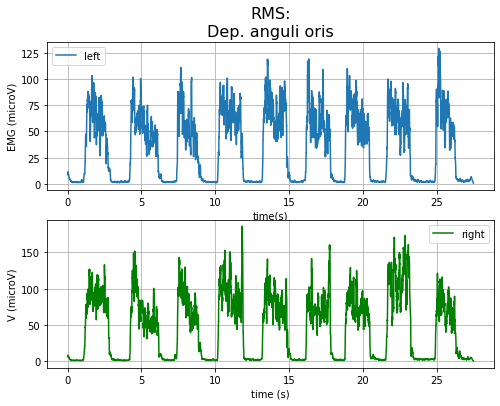

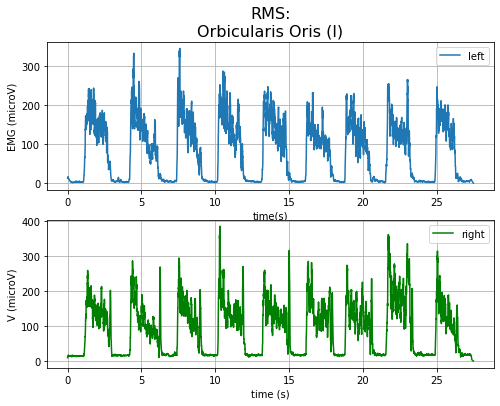

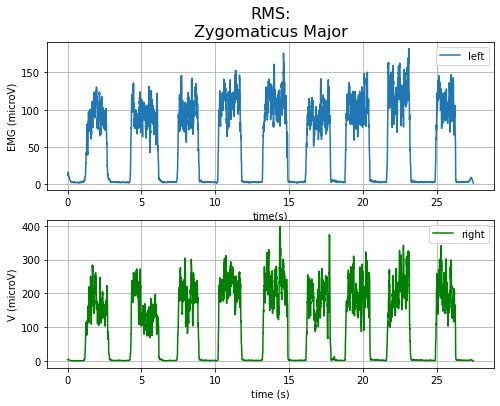

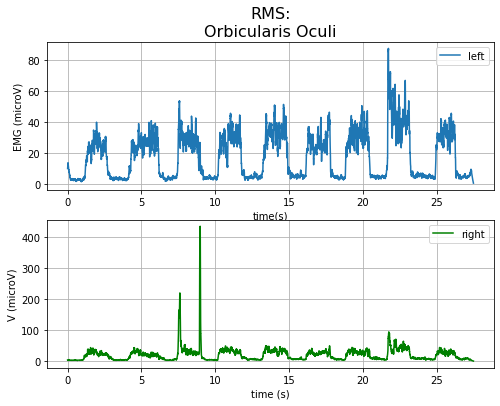

In [20]:
fig, ax = plt.subplots(2,1,figsize = (8,6))
ax[0].plot(df['time'], rms_a1, label = '%s'%l)
ax[0].set_title(r'RMS:'+ '\n' + '%s'%m1, fontsize=16)
ax[0].set_xlabel('time(s)')
ax[0].set_ylabel('EMG (microV)')
ax[0].autoscale()
ax[0].grid()
leg = ax[0].legend()

ax[1].plot(df['time'], rms_b1,'g',label = '%s'%r)
ax[1].set_ylabel("V (microV)")
ax[1].set_xlabel("time (s)")
ax[1].autoscale()
ax[1].grid()
leg = ax[1].legend()

fig, ax = plt.subplots(2,1,figsize = (8,6))
ax[0].plot(df['time'], rms_a2, label = '%s'%l)
ax[0].set_title(r'RMS:'+ '\n' + '%s'%m2, fontsize=16)
ax[0].set_xlabel('time(s)')
ax[0].set_ylabel('EMG (microV)')
ax[0].autoscale()
ax[0].grid()
leg = ax[0].legend()

ax[1].plot(df['time'], rms_b2,'g',label = '%s'%r)
ax[1].set_ylabel("V (microV)")
ax[1].set_xlabel("time (s)")
ax[1].autoscale()
ax[1].grid()
leg = ax[1].legend()

fig, ax = plt.subplots(2,1,figsize = (8,6))
ax[0].plot(df['time'], rms_a3, label = '%s'%l)
ax[0].set_title(r'RMS:'+ '\n' + '%s'%m3, fontsize=16)
ax[0].set_xlabel('time(s)')
ax[0].set_ylabel('EMG (microV)')
ax[0].autoscale()
ax[0].grid()
leg = ax[0].legend()

ax[1].plot(df['time'], rms_b3,'g',label = '%s'%r)
ax[1].set_ylabel("V (microV)")
ax[1].set_xlabel("time (s)")
ax[1].autoscale()
ax[1].grid()
leg = ax[1].legend()

fig, ax = plt.subplots(2,1,figsize = (8,6))
ax[0].plot(df['time'], rms_a4, label = '%s'%l)
ax[0].set_title(r'RMS:'+ '\n' + '%s'%m4, fontsize=16)
ax[0].set_xlabel('time(s)')
ax[0].set_ylabel('EMG (microV)')
ax[0].autoscale()
ax[0].grid()
leg = ax[0].legend()

ax[1].plot(df['time'], rms_b4,'g',label = '%s'%r)
ax[1].set_ylabel("V (microV)")
ax[1].set_xlabel("time (s)")
ax[1].autoscale()
ax[1].grid()
leg = ax[1].legend()

plt.show()

## Comparing Linear Envelope Methods: RMS vs LP - Same Side
    #had to remove of L Orbicularis Oris 1.5 seconds due to large spike

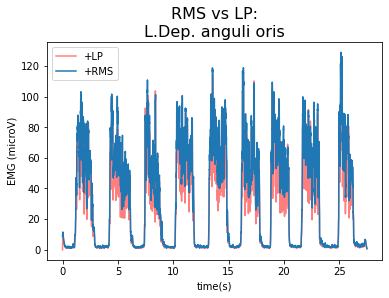

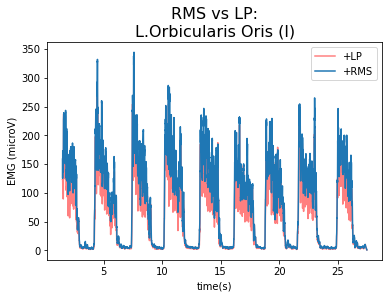

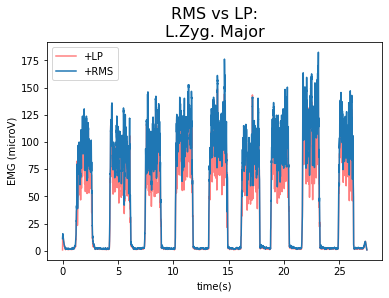

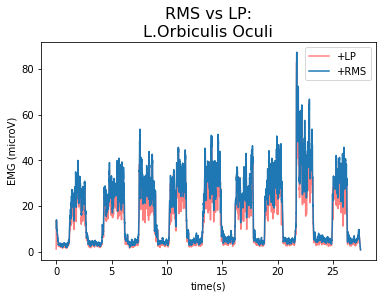

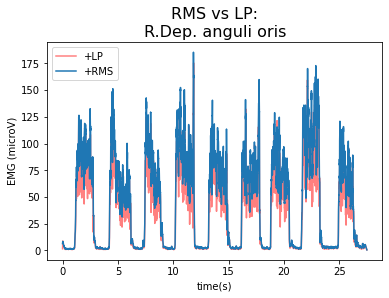

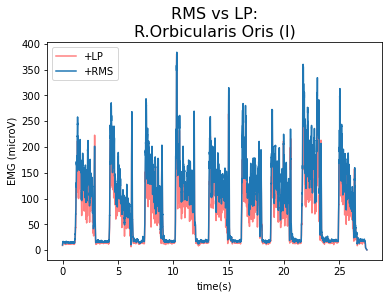

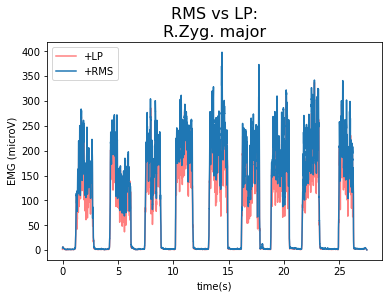

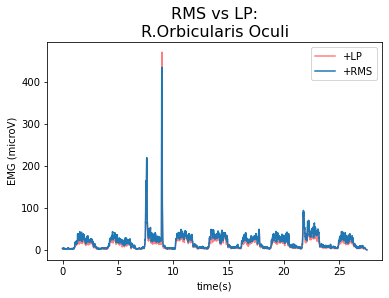

In [21]:
window_size = 100
window = np.ones(window_size)/float(window_size)

fig, ax = plt.subplots()
ax.plot(df['time'], filt_a1,'r',alpha=0.5,label = "+LP")
ax.plot(df['time'], rms_a1, label = '+RMS')
ax.set_title(r'RMS vs LP:'+'\n' '%s'%a1, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'][3000::], filt_a2[3000::],'r',alpha=0.5,label = "+LP")
ax.plot(df['time'][3000::], rms_a2[3000::],label = '+RMS')
ax.set_title(r'RMS vs LP:'+'\n' '%s'%a2, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'], filt_a3,'r',alpha=0.5,label = "+LP")
ax.plot(df['time'], rms_a3, label = '+RMS')
ax.set_title(r'RMS vs LP:'+'\n' '%s'%a3, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'], filt_a4,'r',alpha=0.5,label = "+LP")
ax.plot(df['time'], rms_a4, label = '+RMS')
ax.set_title(r'RMS vs LP:'+'\n' '%s'%a4, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'], filt_b1,'r',alpha=0.5,label = "+LP")
ax.plot(df['time'], rms_b1,label = '+RMS')
ax.set_title(r'RMS vs LP:'+'\n' '%s'%b1, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'], filt_b2,'r',alpha=0.5,label = "+LP")
ax.plot(df['time'], rms_b2,label = '+RMS')
ax.set_title(r'RMS vs LP:'+'\n' '%s'%b2, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'], filt_b3,'r',alpha=0.5,label = "+LP")
ax.plot(df['time'], rms_b3,label = '+RMS')
ax.set_title(r'RMS vs LP:'+'\n' '%s'%b3, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'], filt_b4,'r',alpha=0.5,label = "+LP")
ax.plot(df['time'], rms_b4,label = '+RMS')
ax.set_title(r'RMS vs LP:'+'\n' '%s'%b4, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

## Comparison Plot: Bandpass - L/R

window_size = 250
window = np.ones(window_size)/float(window_size)

fig, ax = plt.subplots()
ax.plot(df['time'], filt_a1,'r',alpha=0.5,label = "Left")
ax.plot(df['time'], filt_b1,label = 'Right')
ax.set_title(r'LP Filter %s HZ:'%fc_low+ '\n' + '%s & %s'%(a1,b1), fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

ax.set_title(r'LP Filter %s HZ:'%fc_low+ '\n' + '%s & %s'%(a1,b1), fontsize=16)

fig, ax = plt.subplots()
ax.plot(df['time'], filt_a2,'r',alpha=0.5,label = "Left")
ax.plot(df['time'], filt_b2,label = 'Right')
ax.set_title(r'LP Filter %s HZ:'%fc_low+ '\n' + '%s & %s'%(a2,b2), fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'], filt_a3,'r',alpha=0.5,label = "+Left")
ax.plot(df['time'], filt_b3,label = 'Right')
ax.set_title(r'LP Filter %s HZ:'%fc_low+ '\n' + '%s & %s'%(a3,b3), fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'], filt_a4,'r',alpha=0.5,label = "Left")
ax.plot(df['time'], filt_b4,label = 'Right')
ax.set_title(r'LP Filter %s HZ:'%fc_low+ '\n' + '%s & %s'%(a4,b4), fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

## Comparison Plot: RMS - L/R

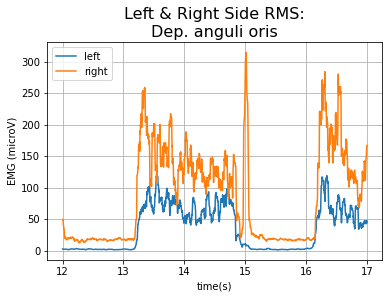

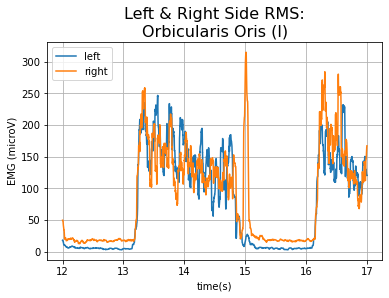

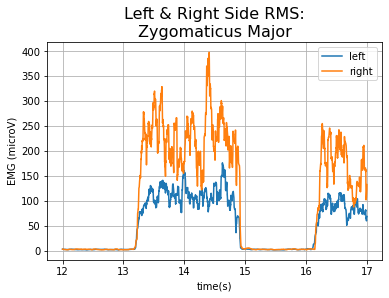

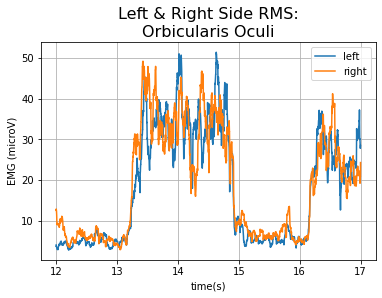

In [22]:

window_size = 250
window = np.ones(window_size)/float(window_size)

fs = 2000
t_low = 12
t_high = 17

i = t_low*fs
j = t_high*fs

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], rms_a1[i:j],label = '%s'%l)
ax.plot(df['time'][i:j], rms_b2[i:j],label = '%s'%r)
ax.set_title(r'Left & Right Side RMS:'+ '\n' + '%s'%m1, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
ax.grid()
leg = ax.legend()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], rms_a2[i:j],label = '%s'%l)
ax.plot(df['time'][i:j], rms_b2[i:j],label = '%s'%r)
ax.set_title(r'Left & Right Side RMS:'+ '\n' + '%s'%m2, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.grid()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], rms_a3[i:j],label = '%s'%l)
ax.plot(df['time'][i:j], rms_b3[i:j],label = '%s'%r)
ax.set_title(r'Left & Right Side RMS:'+ '\n' + '%s'%m3, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.grid()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], rms_a4[i:j],label = '%s'%l)
ax.plot(df['time'][i:j], rms_b4[i:j],label = '%s'%r)
ax.set_title(r'Left & Right Side RMS:'+ '\n' + '%s'%m4, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.grid()
ax.autoscale()

## RMS vs LP - Single Event Comparison - same side
    Select lower-upper time frames

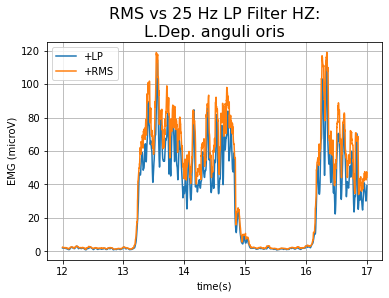

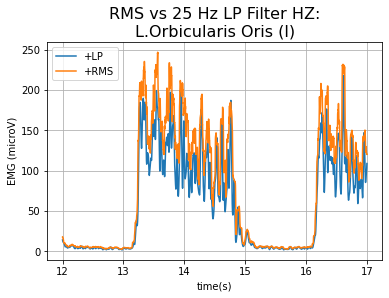

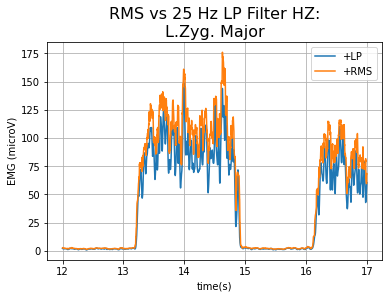

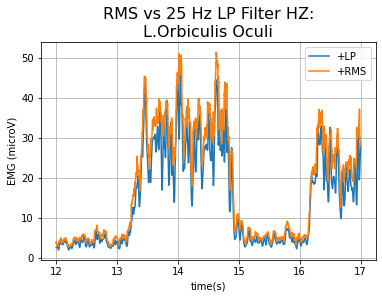

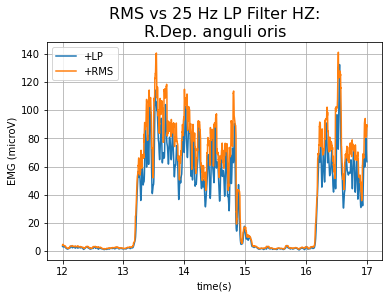

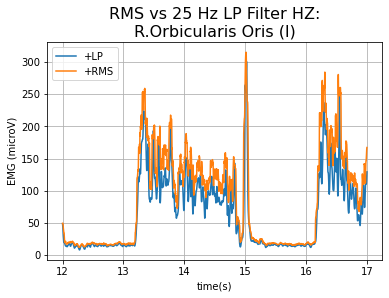

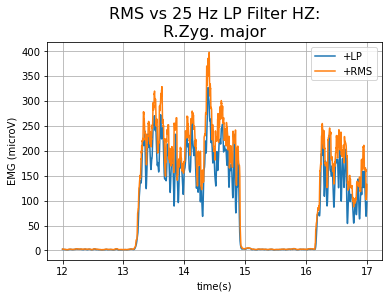

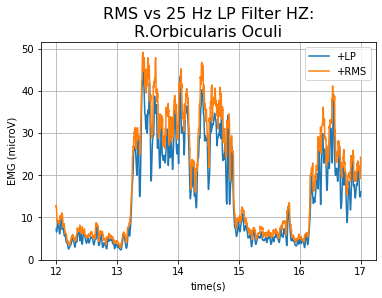

In [23]:
window_size = 250
window = np.ones(window_size)/float(window_size)

fs = 2000
t_low = 12
t_high = 17

i = t_low*fs
j = t_high*fs

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], filt_a1[i:j],label = '+LP')
ax.plot(df['time'][i:j], rms_a1[i:j],label = '+RMS')
ax.set_title(r'RMS vs %s Hz LP Filter HZ:'%fc_low+ '\n' + '%s'%a1, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.grid()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], filt_a2[i:j],label = '+LP')
ax.plot(df['time'][i:j], rms_a2[i:j],label = '+RMS')
ax.set_title(r'RMS vs %s Hz LP Filter HZ:'%fc_low+ '\n' + '%s'%a2, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.grid()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], filt_a3[i:j],label = "+LP")
ax.plot(df['time'][i:j], rms_a3[i:j],label = '+RMS')
ax.set_title(r'RMS vs %s Hz LP Filter HZ:'%fc_low+ '\n' + '%s'%a3, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.grid()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], filt_a4[i:j],label = "+LP")
ax.plot(df['time'][i:j], rms_a4[i:j],label = '+RMS')
ax.set_title(r'RMS vs %s Hz LP Filter HZ:'%fc_low+ '\n' + '%s'%a4, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.grid()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], filt_b1[i:j],label = "+LP")
ax.plot(df['time'][i:j], rms_b1[i:j],label = '+RMS')
ax.set_title(r'RMS vs %s Hz LP Filter HZ:'%fc_low+ '\n' + '%s'%b1, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.grid()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], filt_b2[i:j],label = "+LP")
ax.plot(df['time'][i:j], rms_b2[i:j],label = '+RMS')
ax.set_title(r'RMS vs %s Hz LP Filter HZ:'%fc_low+ '\n' + '%s'%b2, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.grid()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], filt_b3[i:j],label = "+LP")
ax.plot(df['time'][i:j], rms_b3[i:j],label = '+RMS')
ax.set_title(r'RMS vs %s Hz LP Filter HZ:'%fc_low+ '\n' + '%s'%b3, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.grid()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], filt_b4[i:j],label = "+LP")
ax.plot(df['time'][i:j], rms_b4[i:j],label = '+RMS')
ax.set_title(r'RMS vs %s Hz LP Filter HZ:'%fc_low+ '\n' + '%s'%b4, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.grid()
ax.autoscale()

plt.show()

## Single Event Comparison Plot: RMS vs. Rectified Signal
    Select lower-upper time frames

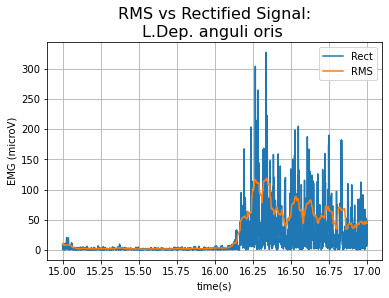

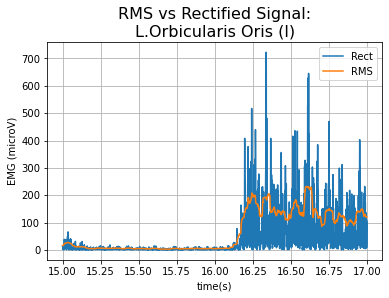

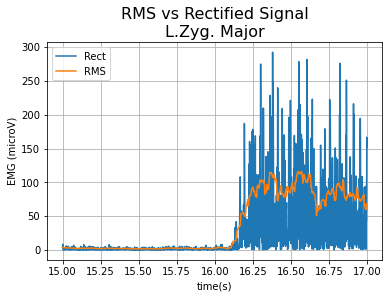

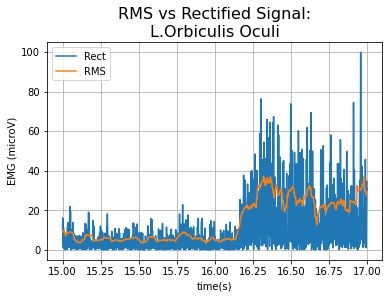

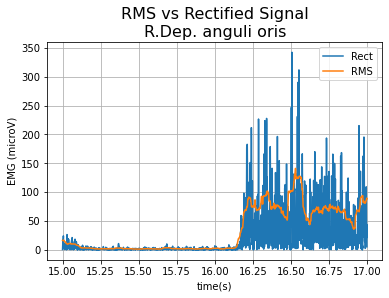

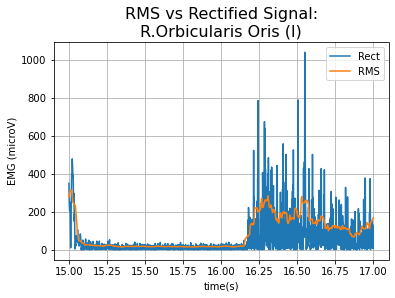

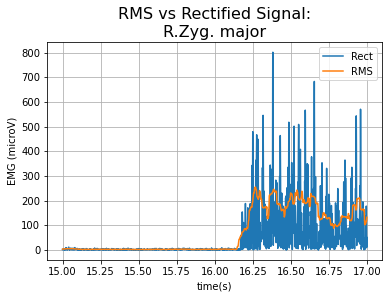

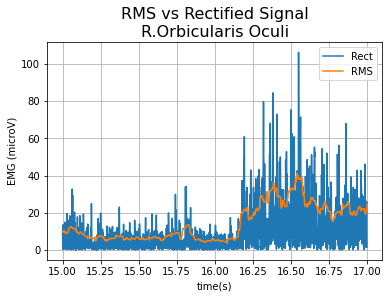

In [24]:
window_size = 100
window = np.ones(window_size)/float(window_size)

fs = 2000
t_low = 15
t_high = 17

i = t_low*fs
j = t_high*fs

r = "Right"
l = "Left"

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], abs_a1[i:j],label = 'Rect')
ax.plot(df['time'][i:j], rms_a1[i:j],label = 'RMS')
ax.set_title(r'RMS vs Rectified Signal:'+ '\n' + '%s '%a1, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()
ax.grid()

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], abs_a2[i:j],label = 'Rect')
ax.plot(df['time'][i:j], rms_a2[i:j],label = 'RMS')
ax.set_title(r'RMS vs Rectified Signal:' '\n' + '%s'%a2, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()
ax.grid()

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], abs_a3[i:j],label = "Rect")
ax.plot(df['time'][i:j], rms_a3[i:j],label = 'RMS')
ax.set_title(r'RMS vs Rectified Signal'+ '\n' + '%s'%a3, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()
ax.grid()

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], abs_a4[i:j],label = "Rect")
ax.plot(df['time'][i:j], rms_a4[i:j],label = 'RMS')
ax.set_title(r'RMS vs Rectified Signal:' + '\n' + '%s'%a4, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()
ax.grid()

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], abs_b1[i:j],label = "Rect")
ax.plot(df['time'][i:j], rms_b1[i:j],label = 'RMS')
ax.set_title(r'RMS vs Rectified Signal' + '\n' + '%s'%b1, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()
ax.grid()

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], abs_b2[i:j],label = "Rect")
ax.plot(df['time'][i:j], rms_b2[i:j],label = 'RMS')
ax.set_title(r'RMS vs Rectified Signal:'+ '\n' + '%s'%b2, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()
ax.grid()

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], abs_b3[i:j],label = "Rect")
ax.plot(df['time'][i:j], rms_b3[i:j],label = 'RMS')
ax.set_title(r'RMS vs Rectified Signal:'+ '\n' + '%s'%b3, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()
ax.grid()

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], abs_b4[i:j],label = "Rect")
ax.plot(df['time'][i:j], rms_b4[i:j],label = 'RMS')
ax.set_title(r'RMS vs Rectified Signal'+ '\n' + '%s'%b4, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()
ax.grid()

plt.show()

In [25]:
import pandas as pd

In [26]:
new_file = pd.DataFrame(columns={'a1': rms_a1, 'a2': rms_a2, 'a3':rms_a3, 'a4':rms_a4,
                                'b1':rms_b1, 'b2':rms_b2,'b3':rms_b3,'b4':rms_b4})

In [27]:
new_file_2 = pd.DataFrame(data={'a1': rms_a1, 'a2': rms_a2, 'a3':rms_a3, 'a4':rms_a4,
                                'b1':rms_b1, 'b2':rms_b2,'b3':rms_b3,'b4':rms_b4})

In [28]:
new_file_2.index = df['time']

In [29]:
new_file_2.to_excel('facial_emg.xlsx')

## Comparing LP - same muscle, different side

window_size = 250
window = np.ones(window_size)/float(window_size)

fs = 2000
t_low = 1
t_high = 30

i = t_low*fs
j = t_high*fs

r = "Right"
l = "Left"

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], filt_a1[i:j],label = "%s"%l)
ax.plot(df['time'][i:j], filt_b1[i:j],label = '+%s'%r)
ax.set_title(r'Left and Right %s Hz LP:'%fc_low+ '\n' + '%s'%b1, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], filt_a3[i:j],label = "%s"%l)
ax.plot(df['time'][i:j], filt_b3[i:j],label = '+%s'%r)
ax.set_title(r'Left and Right %s Hz LP:'%fc_low+ '\n' + '%s'%b2, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], filt_a3[i:j],label = "%s"%l)
ax.plot(df['time'][i:j], filt_b3[i:j],label = '%s'%r)
ax.set_title(r'Left and Right %s Hz LP:'%fc_low+ '\n' + '%s'%b3, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

fig, ax = plt.subplots()
ax.plot(df['time'][i:j], filt_a4[i:j],label = '%s'%l)
ax.plot(df['time'][i:j], filt_b4[i:j],label = '%s'%r)
ax.set_title(r'Left and Right %s Hz LP:'%fc_low+ '\n' + '%s'%b4, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.autoscale()

plt.show()

## Comparing RMS Plot - same muscle, different side
    ## do not follow headers, not done yet
    ## add LP only for a side by side

(5.0, 10.0)

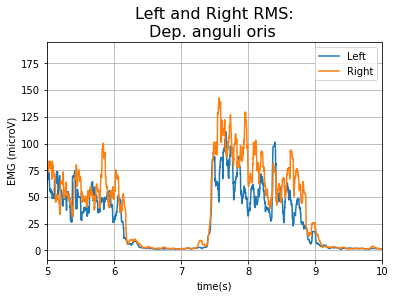

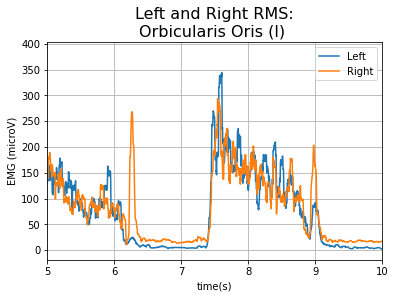

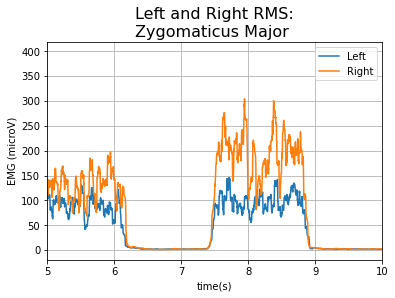

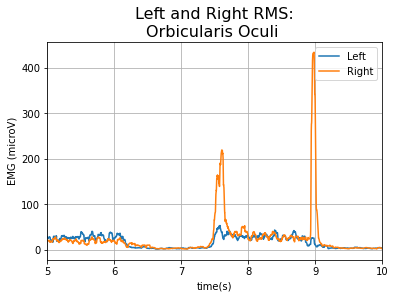

In [30]:
x_lower = 5
x_upper = 10

fig, ax = plt.subplots()
ax.plot(df['time'], rms_a1,label = "%s"%l)
ax.plot(df['time'], rms_b1,label = '%s'%r)
ax.set_title(r'Left and Right RMS:' + '\n' + '%s '%m1, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.grid()
ax.set_xlim([x_lower,x_upper])

fig, ax = plt.subplots()
ax.plot(df['time'], rms_a2,label = "%s"%l)
ax.plot(df['time'], rms_b2,label = '%s'%r)
ax.set_title(r'Left and Right RMS:' + '\n' + '%s '%m2, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.grid()
ax.set_xlim([x_lower,x_upper])

fig, ax = plt.subplots()
ax.plot(df['time'], rms_a3,label = "%s"%l)
ax.plot(df['time'], rms_b3,label = '%s'%r)
ax.set_title(r'Left and Right RMS:' + '\n' + '%s '%m3, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.grid()
ax.set_xlim([x_lower,x_upper])

fig, ax = plt.subplots()
ax.plot(df['time'], rms_a4,label = "%s"%l)
ax.plot(df['time'], rms_b4,label = '%s'%r)
ax.set_title(r'Left and Right RMS:' + '\n' + '%s '%m4, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('EMG (microV)')
leg = ax.legend()
ax.grid()
ax.set_xlim([x_lower,x_upper])


In [31]:
import numpy as np
def window_rms(a, window_size):
  a2 = np.power(a,2)
  window = np.ones(window_size)/float(window_size)
  return np.sqrt(np.convolve(a2, window, 'valid'))

## Comparing Raw vs. Filtered PSD

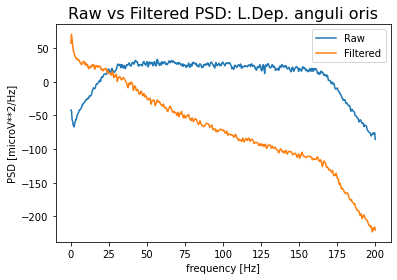

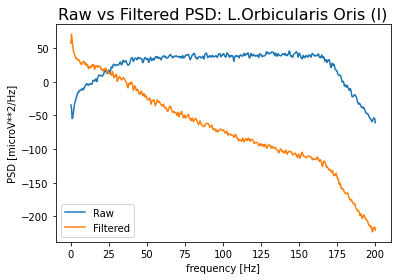

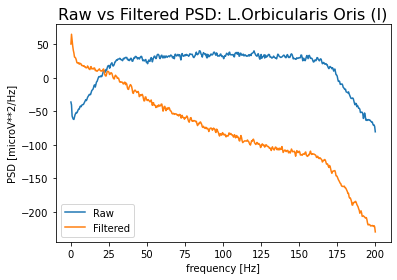

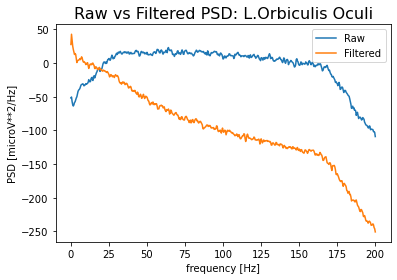

In [32]:
fs = 2000

f1, Pxx_raw_den_a1 = signal.welch(signal.decimate(emg1,5), fs/5, nperseg=1024)
f_filt_a1, Pxx_filt_den_a1 = signal.welch(signal.decimate(filt_a2,5), fs/5, nperseg=1024)

fig, ax = plt.subplots()
ax.plot(f1, 20*np.log10(np.abs(Pxx_raw_den_a1)),label = "Raw" )
ax.plot(f_filt_a1, 20*np.log10(np.abs(Pxx_filt_den_a1)),label = "Filtered")
ax.set_title(r'Raw vs Filtered PSD: %s'%a1, fontsize=16)
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [microV**2/Hz]')
leg = ax.legend();


f_filt_a2, Pxx_filt_den_a2 = signal.welch(signal.decimate(filt_a2,5), fs/5, nperseg=1024)

fig, ax = plt.subplots()
ax.plot(f2, 20*np.log10(np.abs(Pxx_raw_den_a2)), label = "Raw")
ax.plot(f_filt_a2, 20*np.log10(np.abs(Pxx_filt_den_a2)),label = "Filtered")
ax.set_title(r'Raw vs Filtered PSD: %s'%a2, fontsize=16)
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [microV**2/Hz]')
leg = ax.legend();


f3, Pxx_raw_den_a3 = signal.welch(signal.decimate(emg3,5), fs/5, nperseg=1024)
f_filt_a3, Pxx_filt_den_a3 = signal.welch(signal.decimate(filt_a3,5), fs/5, nperseg=1024)

fig, ax = plt.subplots()
ax.plot(f3, 20*np.log10(np.abs(Pxx_raw_den_a3)),label = "Raw")
ax.plot(f_filt_a3, 20*np.log10(np.abs(Pxx_filt_den_a3)),label = "Filtered")
ax.set_title(r'Raw vs Filtered PSD: %s'%a2, fontsize=16)
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [microV**2/Hz]')
leg = ax.legend();


f4, Pxx_raw_den_a4 = signal.welch(signal.decimate(emg4,5), fs/5, nperseg=1024)
f_filt_a4, Pxx_filt_den_a4 = signal.welch(signal.decimate(filt_a4,5), fs/5, nperseg=1024)

fig, ax = plt.subplots()
ax.plot(f4, 20*np.log10(np.abs(Pxx_raw_den_a4)),label = "Raw")
ax.plot(f_filt_a4, 20*np.log10(np.abs(Pxx_filt_den_a4)), label = "Filtered")
ax.set_title(r'Raw vs Filtered PSD: %s'%a4, fontsize=16)
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [microV**2/Hz]')
leg = ax.legend();

plt.show()

## Introducing Kinematic Data - Low Pass

In [33]:
kin = pd.read_csv(r"subject1_smile_1_landmarks.csv", index_col = None)

In [34]:
mouthFrame = kin['Frame_number'] 

pos_top = kin[['landmark_62_x', 'landmark_62_y']].to_numpy()
pos_bottom = kin[['landmark_66_x', 'landmark_66_y']].to_numpy()

pos_derecha = kin[['landmark_51_x', 'landmark_51_y']].to_numpy()
pos_izquierda = kin[['landmark_57_x', 'landmark_57_y']].to_numpy()

In [35]:
mouthFrame = np.flip(mouthFrame.values)

## Filtering Kinematic Data

In [36]:
fps = 100
fc_low_image = 15 #
lp_order = 2
z3, w3 = sp.signal.bessel(lp_order, Wn = fc_low_image/ (fps / 2), btype = 'lowpass', analog = False)

In [37]:
distanceVertical = np.flip(np.linalg.norm(pos_top-pos_bottom, axis=1))
distanceHoriz = np.flip(np.linalg.norm(pos_derecha-pos_izquierda, axis=1))

In [38]:
#Apply filter to kinematic data
filt_distanceVertical = sp.signal.filtfilt(z3, w3, distanceVertical)
filt_distanceHoriz = sp.signal.filtfilt(z3, w3, distanceHoriz)

## Comparison Plot: Raw vs. LP Filtered Displacements

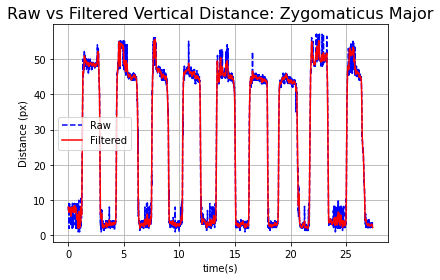

In [39]:
fig, ax = plt.subplots()
ax.plot(mouthFrame/fps, distanceVertical,'--b',label = "Raw" )
ax.plot(mouthFrame/fps, filt_distanceVertical,'r',label = "Filtered")
ax.set_title(r'Raw vs Filtered Vertical Distance: %s'%m3, fontsize=16)
ax.set_xlabel('time(s)')
ax.set_ylabel('Distance (px)')
ax.grid()
leg = ax.legend()

## Plotting RMS vs Landmarks (Mouth Vertical)

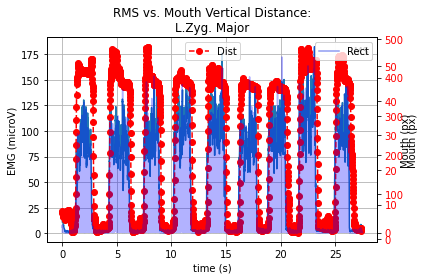

In [40]:
fps = 100
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('EMG (microV)')
ax1.plot(df['time'], rms_a3,label = 'RMS')
ax1.set_title('RMS vs. Mouth Vertical Distance:' +'\n' + '%s'%a3)
ax1.tick_params(axis='y')
leg1 = ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
ax2.plot(mouthFrame/fps, filt_distanceVertical,'--o',label = 'Dist', color = 'r')
ax2.tick_params(axis='y', labelcolor='r')
leg2 = ax2.legend()

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
ax3.plot(df['time'], abs_a3,label = 'Rect', color = 'b',alpha = 0.3)
ax3.tick_params(axis='y', labelcolor='r')
ax1.grid()
leg3 = ax3.legend()

fig.tight_layout() 

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [41]:
df.head()

,time,a1,a2,a3,a4,b1,b2,b3,b4
0,0.0000,-6.017704e-13,-9.593442e-13,-9.855081e-13,-7.936393e-13,7.325901e-13,1.404131e-12,5.843278e-13,2.703606e-13
1,0.0005,-5.094890e-07,-8.122304e-07,-8.343824e-07,-6.719360e-07,6.202469e-07,1.188809e-06,4.947228e-07,2.289007e-07
2,0.0010,-1.052261e-05,-1.689578e-05,-1.738180e-05,-1.397741e-05,1.276352e-05,2.464100e-05,1.034150e-05,4.711096e-06
3,0.0015,-1.165233e-05,-2.011176e-05,-2.109853e-05,-1.655467e-05,1.328889e-05,2.811801e-05,1.278868e-05,4.918559e-06
4,0.0020,-1.120676e-05,-1.834543e-05,-2.033471e-05,-1.441966e-05,1.067679e-05,2.423735e-05,1.048404e-05,3.556361e-06


In [42]:
s1 = pd.Series(filt_distanceVertical)
s2 = pd.Series(filt_distanceHoriz)
df_test = pd.DataFrame({"vertical":filt_distanceVertical,"horizontal":filt_distanceHoriz})
df_test.set_index(mouthFrame/fps)

,vertical,horizontal
0.00,8.062274,67.067157
0.01,7.665864,66.831859
0.02,7.466296,66.942656
0.03,7.484147,67.523487
0.04,7.506952,68.321437
...,...,...
27.35,3.042361,63.377775
27.36,2.978929,64.126844
27.37,2.818283,64.561202
27.38,2.549013,64.874562


In [43]:
df1 = pd.DataFrame({"rms_a3":rms_a3,"rms_b3":rms_b3})
df1['time'] = df['time']

In [44]:
df3['time']=(mouthFrame/fps)

NameError: name 'df3' is not defined

In [ ]:
df1

In [ ]:
sepa = df1.merge(df3.drop_duplicates(subset=['time']),on='outer' ,how='left')

In [ ]:
sepa.to_excel("sepa2.xlsx") 

In [ ]:
combined = pd.merge_ordered(df1,df3,on='time')

In [ ]:
combined.drop_duplicates(subset=['time'],keep='first')

In [ ]:
new_file = pd.read_xls

In [ ]:
combined.to_excel("output_dropped.xlsx")  

## Plotting RMS vs Landmarks (Mouth Horizontal)

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('EMG (microV)')
ax1.plot(df['time'], rms_a3,label = '%s'%m3)
ax1.set_title('RMS vs. Mouth Horizontal distance:' +'\n' + '%s'%a3)
ax1.tick_params(axis='y')
leg1 = ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
ax2.plot(mouthFrame/fps, filt_distanceHoriz,'--o',label = 'Dist', color = 'r')
ax2.tick_params(axis='y', labelcolor='r')
leg2 = ax2.legend()

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
ax3.plot(df['time'], abs_a3,label = 'Rectified', color = 'b',alpha = 0.3)
ax3.tick_params(axis='y', labelcolor='r')
ax1.grid()
leg3 = ax3.legend()

fig.tight_layout() 

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Calculate Power of a signal

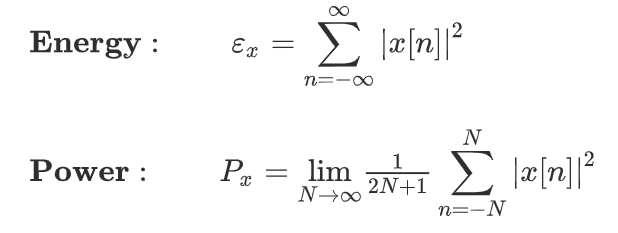

In [ ]:
fig, ax1 = plt.subplots()
# Zygomaticus major
E_a3 = (abs_a3**2)
P_a3 = E_a3/(2*N_samples+1)

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('EMG (microV)')
ax1.plot(df['time'], rms_a3,label = 'RMS')
ax1.set_title('RMS vs. Mouth Horizontal distance vs Power:' +'\n' + '%s'%a3)
ax1.tick_params(axis='y')
ax1.legend(loc = "upper left")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
ax2.plot(mouthFrame/fps, filt_distanceHoriz,'--o',label = 'Dist', color = 'r')
ax2.tick_params(axis='y', labelcolor='r')
leg2 = ax2.legend(loc = "upper center")

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
ax3.plot(df['time'], P_a3,label = 'Power', color = 'b',alpha = 0.3)
ax3.tick_params(axis='y', labelcolor='r')
ax1.grid()
leg3 = ax3.legend(loc = "upper right")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Finding Peaks of Filtered Kinematic Data (Mouth Horizontal)

In [ ]:
from scipy.signal import find_peaks
x = filt_distanceHoriz
peaks, _ = find_peaks(x, height=0)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

## Plotting Power, RMS, and Displacement: Single Event (Mouth Horizontal)

In [ ]:
%matplotlib qt

window_size = 100
window = np.ones(window_size)/float(window_size)

r = "Right"
l = "Left"

fs = 2000
fps = 100

t_low1 = 1
t_high1 = 3

t_low2 = 4
t_high2 = 7

t_low3 = 7
t_high3 = 9

t_low4 = 10
t_high4 =12

t_low5 = 13
t_high5 = 15

t_low6 = 16
t_high6 =18

t_low7 = 18 # better at 18.6 and 20.5
t_high7 =21

t_low8 = 21 # 21.6 and 23.4
t_high8 =23

t_low9 = 25 # 24.9 and 26.4
t_high9 =27

# t_low10 = 3
# t_high10 =5

# isolate single events
    
i1 = t_low1*fs #indexing for EMG (convert to time)
j1 = t_high1*fs
i11 = t_low1*fps #indexing for images (convert to time)
j11 = t_high1*fps
                    # repeat for all
i2 = t_low2*fs
j2 = t_high2*fs
i22 = t_low2*fps
j22 = t_high2*fps

i3 = t_low3*fs
j3 = t_high3*fs
i33 = t_low3*fps
j33 = t_high3*fps

i4 = t_low4*fs
j4 = t_high4*fs
i44 = t_low4*fps
j44 = t_high4*fps

i5 = t_low5*fs
j5 = t_high5*fs
i55 = t_low5*fps
j55 = t_high5*fps

i6 = t_low6*fs
j6 = t_high6*fs
i66 = t_low6*fps
j66 = t_high6*fps

i7 = t_low7*fs
j7 = t_high7*fs
i77 = t_low7*fps
j77 = t_high7*fps

i8 = t_low8*fs
j8 = t_high8*fs
i88 = t_low8*fps
j88 = t_high8*fps

i9 = t_low9*fs
j9 = t_high9*fs
i99 = t_low9*fps
j99 = t_high9*fps

# i10 = t_low10*fs
# j10= t_high10*fs
# i1010 = t_low10*fps
# j1010 = t_high10*fps

P_1 = P_a3[i1:j1]
P_2 = P_a3[i2:j2]
P_3 = P_a3[i3:j3]
P_4 = P_a3[i4:j4]
P_5 = P_a3[i5:j5]
P_6 = P_a3[i6:j6]
P_7 = P_a3[i7:j7]
P_8 = P_a3[i8:j8]
P_9 = P_a3[i9:j9]
# P_10 = P_a3[i10:j10]

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('EMG (microV)')
ax1.plot(df['time'][i1:j1], P_1,label = 'Power', color = 'g')
ax1.set_title('RMS vs. Mouth Horizontal distance:' +'\n' + '%s'%a3)
ax1.tick_params(axis='y')
leg = ax1.legend(loc = 'upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
ax2.plot(mouthFrame[i11:j11]/fps, filt_distanceHoriz[i11:j11],'--o',label = 'Dist', color = 'r')
ax2.tick_params(axis='y', labelcolor='r')
leg = ax2.legend(loc = 'upper center')

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax3.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
ax3.plot(df['time'][i1:j1], rms_a3[i1:j1],label = 'Rectified', color = 'b',alpha = 0.3)
ax3.tick_params(axis='y', labelcolor='r')
leg = ax3.legend(loc = 'upper right')

ax1.grid()
fig.tight_layout() 

                            ## SECOND IMPULSE
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('EMG (microV)')
ax1.plot(df['time'][i2:j2], P_2,label = 'Power', color = 'g')
ax1.set_title('RMS vs. Mouth Horizontal distance:' +'\n' + '%s'%a3)
ax1.tick_params(axis='y')
leg = ax1.legend(loc = 'upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
ax2.plot(mouthFrame[i22:j22]/fps, filt_distanceHoriz[i22:j22],'--o',label = 'Dist', color = 'r')
ax2.tick_params(axis='y', labelcolor='r')
leg = ax2.legend(loc = 'upper center')

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax3.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
ax3.plot(df['time'][i2:j2], rms_a3[i2:j2],label = 'Rectified', color = 'b',alpha = 0.3)
ax3.tick_params(axis='y', labelcolor='r')
leg = ax3.legend(loc = 'upper right')

ax1.grid()
fig.tight_layout() 

## Plot Power, RMS, and filtered Kinematic Data: Whole period (Mouth Horizontal)

In [ ]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('EMG (microV)')
ax1.plot(df['time'], rms_a3,label = '%s'%m3)
ax1.set_title('RMS vs. Mouth Horizontal Distance - Smile:' +'\n' + '%s'%a3)
ax1.tick_params(axis='y')
leg1 = ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
ax2.plot(mouthFrame/fps, filt_distanceHoriz,'--o',label = 'Dist', color = 'r')
ax2.tick_params(axis='y', labelcolor='r')
leg2 = ax2.legend()

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
ax3.plot(df['time'], abs_a3,label = 'Rectified', color = 'b',alpha = 0.3)
ax3.tick_params(axis='y', labelcolor='r')
ax1.grid()
leg3 = ax3.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Plot Power, RMS, and filtered Kinematic Data: Whole period (Mouth Horizontal)

In [ ]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('EMG (microV)')
ax1.plot(df['time'], rms_a3,label = '%s'%m3)
ax1.set_title('RMS vs. Mouth Vertical distance:' +'\n' + '%s'%a3)
ax1.tick_params(axis='y')
leg1 = ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
ax2.plot(mouthFrame/fps, filt_distanceVertical,'--o',label = 'Dist', color = 'r')
ax2.tick_params(axis='y', labelcolor='r')
leg2 = ax2.legend()

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
ax3.plot(df['time'], abs_a3,label = 'Rectified', color = 'b',alpha = 0.3)
ax3.tick_params(axis='y', labelcolor='r')
ax1.grid()
leg3 = ax3.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Average Power
    you have to find and isolate key points of interest

In [ ]:
displacement =[]
for i in range(1,10):
    var1 = int(eval(f'i{i}{i}'))
    var2 = int(eval(f'j{i}{i}'))

    low_pos = filt_distanceVertical[var1:var1+10].mean()
    high_pos = filt_distanceVertical[int((var2-var1)/2 + var1)-10:int((var2-var1)/2 + var1)+10].mean()
    
    displacement.append(high_pos-low_pos)

Power_average = [P_1.sum(),P_2.sum(),P_3.sum(),P_4.sum(),P_5.sum(),
                 P_6.sum(),P_7.sum(),P_8.sum(),P_9.sum()]


fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Power')
ax1.set_ylabel('Displacement (px)')
#ax1.plot(distanceVertical[i11:j11],'--o',color = 'r')
ax1.set_title('Power vs. Mouth Vertical distance:' +'\n' + '%s'%a3)
#plt.tick_params(axis='y')

PA = np.array(Power_average)
DA = np.array(displacement)
ax1.scatter(PA[DA>30], DA[DA>30])
plt.show()

## Calculating Velocity and Acceleration (Horizontal)

In [ ]:
low_pass_horiz = 5
order_lp_horiz = 2
z5, w5 = sp.signal.bessel(order_lp_horiz, low_pass_horiz, btype='lowpass',analog = False, output= 'ba', fs = 100)

In [ ]:
crazy_distanceHoriz = sp.signal.filtfilt(z5, w5, distanceHoriz)

In [ ]:
filt_veloHoriz = np.gradient(filt_distanceHoriz)
accHoriz = np.gradient(filt_veloHoriz)

In [ ]:
plt.plot(mouthFrame/fps, veloHoriz)
plt.grid()

In [ ]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('EMG (microV)')
ax1.plot(mouthFrame/fps, crazy_distanceHoriz,label = 'Displacement',)
ax1.set_title('Mouth Horizontal distance vs. Velocity:' +'\n' + '%s'%a3)
ax1.tick_params(axis='y')
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Mouth (px/s)')  # we already handled the x-label with ax1
ax2.plot(mouthFrame/fps, veloHoriz,label = 'Vel', color = 'r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc = "upper left")

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax3.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
ax3.plot(df['time'], rms_a3, color = 'b', alpha = 0.3)
ax3.tick_params(axis='y', labelcolor='r')

ax1.grid()
fig.tight_layout() 

In [ ]:
# distanceVertical_average = pd.DataFrame(distanceVertical_average)
# distanceVertical_average.head()

In [ ]:
# Power_average = pd.DataFrame(Power_average)
# Power_average.head()

In [ ]:
distanceVertical_average = pd.DataFrame({'Displacement': distanceVertical_average})
  
Power_average = pd.DataFrame({'Power': Power_average,})
  
# the default behaviour is join='outer'
# inner join
  
result = pd.concat([Power_average, distanceVertical_average], axis=1, join='inner')
display(result)

In [ ]:
x = result['Power']
y = result['Displacement']

low_pos = distanceVertical[i11:i11+10].mean()
high_pos = distanceVertical[int((j11-i11)/2 + i11)-10:int((j11-i11)/2 + i11)+10].mean()

power = P_1.mean()

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Power')
ax1.set_ylabel('Displacement (px)')
ax1.plot(rms_a3,'--o',color = 'r')
ax1.set_title('Power vs. Mouth Vertical distance:' +'\n' + '%s'%a3)
#plt.tick_params(axis='y')

ax1.scatter((high_pos-low_pos), power)
plt.show()

## FINAL PLOT

In [ ]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Power (W)')
ax1.plot(df['time'], P_a3,label = 'Power', color = 'g', alpha = 0.5)
ax1.set_title('Smile:' +'\n' + '%s'%a3)
ax1.tick_params(axis='y', labelcolor='g')
ax1.tick_params(axis='y')
ax1.yaxis.label.set_color('g') 
leg = ax1.legend(loc = 'upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
ax2.plot(mouthFrame/fps, distanceHoriz,'--o',label = 'Displacement', color = 'r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.yaxis.label.set_color('r') 
leg = ax2.legend(loc = 'upper center')

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax3.plot(mouthFrame/fps, filt_distanceHoriz,label = 'RMS', color = 'b',alpha = 0.5)
ax3.tick_params(axis='y', labelcolor='b')
ax3.set_ylabel('EMG (microV)')
leg = ax3.legend(loc = 'upper right')
ax3.yaxis.label.set_color('b') 
plt.ylabel("Voltage (microV)", labelpad=15)
p3, = ax3.plot(df['time'], rms_a3, color='b', label="Voltage")

# ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
# ax4.set_ylabel('Mouth (px/s)')  # we already handled the x-label with ax1
# ax4.plot(mouthFrame/fps, veloHoriz,label = 'Velocity', color = 'k', alpha = 0.7)
# ax4.tick_params(axis='y', labelcolor='k')
# # leg = ax4.legend(loc = 'lower right')
# ax4.yaxis.label.set_color('k') 

ax1.grid()
fig.tight_layout() 

In [ ]:
new_fie = pd.DataFrame(columns=[filt])

## misma cosa pero limpio

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig, host = plt.subplots(figsize=(10,5)) 
host.set_title('Smile - Horizontal:' +'\n' + '%s'%m3)

par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlabel("Time (s)")
host.set_ylabel("Voltage (microV)")
par1.set_ylabel("Displacement (px)")
par2.set_ylabel("Voltage (microV)")
# par3.set_ylabel("Voltage (microV)")

p1, = host.plot(df['time'], rms_a3,label = 'Left', color = 'b')
p2, = par1.plot(mouthFrame/fps, filt_distanceHoriz,'--o',label = 'Displacement', color = 'r')
p3, = par2.plot(df['time'], rms_b3, color='g', label="Right")

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))
            
host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

plt.tick_params(axis='x', which='major', labelsize=5)

host.grid()
fig.tight_layout() 

## finding average baselines

In [ ]:
filt_distanceHoriz_baseline = [filt_distanceHoriz[0:100].mean(), filt_distanceHoriz[320:400].mean(),
                               filt_distanceHoriz[650:720].mean(), filt_distanceHoriz[920:1000].mean(),
                               filt_distanceHoriz[1215:1300].mean(), filt_distanceHoriz[1500:1600].mean(),
                               filt_distanceHoriz[1815:1875].mean(), filt_distanceHoriz[2100:2150].mean(),
                               filt_distanceHoriz[2370:2450].mean(), filt_distanceHoriz[2700::].mean()
                              ]

In [ ]:
filt_distanceHoriz[0:100].mean()

In [ ]:
filt_rms_baseline = [rms_a3[0:100].mean(), rms_a3[320:400].mean(),
                               rms_a3[650:720].mean(), rms_a3[920:1000].mean(),
                               rms_a3[1215:1300].mean(), rms_a3[1500:1600].mean(),
                               rms_a3[1815:1875].mean(), rms_a3[2100:2150].mean(),
                               rms_a3[2370:2450].mean(), rms_a3[2700::].mean()
                              ]

In [ ]:
filt_rms_baseline_left = [rms_b3[0:100].mean(), rms_b3[300:400].mean(),
                               rms_b3[650:720].mean(), rms_b3[900:1000].mean(),
                               rms_b3[1200:1300].mean(), rms_b3[1500:1600].mean(),
                               rms_b3[1815:1850].mean(), rms_b3[2100:2150].mean(),
                               rms_b3[2350:2450].mean(), rms_b3[2700::].mean()
                              ]

In [ ]:
print((filt_rms_baseline_left))

In [ ]:
print((filt_rms_baseline))

In [ ]:
kin_threshold = sum(filt_distanceHoriz_baseline)/len(filt_distanceHoriz_baseline)
print(kin_threshold)

In [ ]:
instances = []
above_thres = False
testing = pd.DataFrame(filt_distanceHoriz)
for i in range(len(filt_distanceHoriz)):
    if above_thres == False:
        if (testing[0][i] >= max(filt_distanceHoriz_baseline)):
            instances.append(i)
            above_thres = True
    else:
        if (testing[0][i] <= max(filt_distanceHoriz_baseline)):
            instances.append(i)
            above_thres = False

In [ ]:
instances = instances[4::]

In [ ]:
instances = np.array(instances)/fps

In [ ]:
print(instances)

In [ ]:
instances_rms = []
above_thres = False
testing_rms = pd.DataFrame(rms_a3)
for i in range(len(rms_a3)):
    if above_thres == False:
        if (testing_rms[0][i] >= max(filt_rms_baseline)):
            instances_rms.append(i)
            above_thres = True
    else:
        if (testing_rms[0][i] <= max(filt_rms_baseline)):
            instances_rms.append(i)
            above_thres = False

In [ ]:
instances_rms_left = []
above_thres = False
testing_rms_left = pd.DataFrame(rms_b3)
for i in range(len(rms_a3)):
    if above_thres == False:
        if (testing_rms_left[0][i] >= max(filt_rms_baseline)):
            instances_rms_left.append(i)
            above_thres = True
    else:
        if (testing_rms_left[0][i] <= max(filt_rms_baseline)):
            instances_rms_left.append(i)
            above_thres = False